# eBird Stats

This notebook is for generating some plots for one's personal [eBird](https://ebird.org) data. You can request your personal records from eBird [here](https://ebird.org/downloadMyData).

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt   
import re

# read data export downloaded form eBird
df = pd.read_csv('data/MyEBirdData.csv') 

In [3]:
# Pre-processing 
# Drop subspecies from common names
df['Common Name'] = df['Common Name'].map(lambda row: re.sub("\(.*?\)","", row)) 

# Drop slashes and spuhs 
df = df.drop(df[df['Common Name'].str.contains('sp.')].index) 
df = df.drop(df[df['Common Name'].str.contains('/')].index)

# Drop entries where reported quantity is 'X'
df = df.drop(df[df['Count'] == 'X'].index)
df['Count'] = df['Count'].astype(int) 

# Convert Date and Time to datetime
df['Date'] = pd.to_datetime(df['Date']) 

print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12985 entries, 0 to 13269
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Submission ID           12985 non-null  object        
 1   Common Name             12985 non-null  object        
 2   Scientific Name         12985 non-null  object        
 3   Taxonomic Order         12985 non-null  int64         
 4   Count                   12985 non-null  int64         
 5   State/Province          12985 non-null  object        
 6   County                  12984 non-null  object        
 7   Location ID             12985 non-null  object        
 8   Location                12985 non-null  object        
 9   Latitude                12985 non-null  float64       
 10  Longitude               12985 non-null  float64       
 11  Date                    12985 non-null  datetime64[ns]
 12  Time                    12985 non-null  object

# Basic stats

In [4]:
# Top 20 species you've every reported reported 
top = df[['Common Name', 'Count']].groupby('Common Name').count()
top.sort_values(by='Count', ascending=False).head(10)

,Count
Common Name,
Black-capped Chickadee,470
American Robin,438
Blue Jay,409
Song Sparrow,372
Northern Cardinal,353
American Goldfinch,339
American Crow,309
Canada Goose,304
Mallard,280


In [5]:
# Top species reported by number of birds you've actually reported
topcount = df[['Common Name', 'Count']].groupby('Common Name').sum() 
topcount.sort_values(by='Count', ascending=False).head(10) 

,Count
Common Name,
Canada Goose,11973
Common Eider,6311
Snow Goose,4223
Red-winged Blackbird,3562
American Robin,3056
Mallard,2797
Tree Swallow,2441
European Starling,1992
Ring-billed Gull,1991


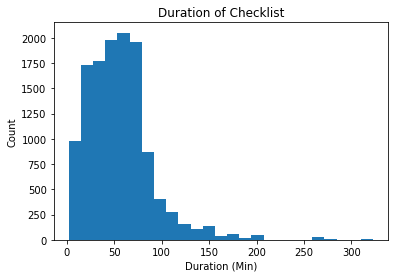

In [6]:
# Typical checklist duration

plt.hist(df['Duration (Min)'], bins=25) 
plt.xlabel("Duration (Min)")
plt.ylabel('Count')
plt.title('Duration of Checklist')
plt.show()

# Streaks

eBird keeps track of your current streak for submitting checklists, and your maximum streak. These next few cells allow you to explore your own streaks and look at the beginning and end dates of your longest streaks.

In [5]:
# Grab the date columna and convert it to datetime, sort it, etc.
dates = df[['Date']].sort_values(by='Date').groupby('Date').count().reset_index()
dates['Date'] = pd.to_datetime(dates['Date'])

# Calculate the difference between consecutive days
dates['diff'] = dates['Date'].diff().dt.days 

# Find streaks: start a new streak any time it has been more than one day since you last birded
dates['streak_id'] = (dates['diff'] != 1).cumsum()  

# Calculate streak length and merge it back to the date df
streak_length = dates.groupby('streak_id').size().reset_index(name='length') 
dates = dates.merge(streak_length, on='streak_id') 

# Find the beginning, end, and duration of the streak 
streak_dates = dates.groupby('streak_id').agg(
    start_date=('Date', 'min'),
    end_date=('Date', 'max'), 
    length=('length', 'max')
).reset_index() 

# display results! 
streak_dates = streak_dates.sort_values(by='length', ascending=False) 
streak_dates.head(10)

,streak_id,start_date,end_date,length
253,254,2024-04-21,2024-05-12,22
245,246,2024-03-06,2024-03-25,20
44,45,2020-11-12,2020-11-29,18
76,77,2021-05-21,2021-06-06,17
72,73,2021-04-17,2021-04-29,13
205,206,2023-06-30,2023-07-11,12
34,35,2020-09-24,2020-10-05,12
74,75,2021-05-06,2021-05-17,12
228,229,2023-11-18,2023-11-28,11
27,28,2020-08-20,2020-08-28,9


# Time of Year

## Average number of species per checklist by month

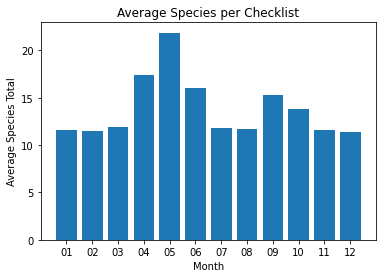

In [8]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# only consider "complete checklists" 
complete = df[df['All Obs Reported'] == 1] 

# get total number of species reported on each checklist
checklist_totals = complete[['Submission ID', 'Common Name']].groupby('Submission ID').count()

# fix indexing and rename columns
checklist_totals  = checklist_totals.reset_index().rename(columns={'Common Name': 'Species Count'}) 


# get monthly list of checklists and isolate the month into its own column 
monthly = df[['Submission ID', 'Date']].groupby('Submission ID').min()
monthly['Month'] = monthly['Date'].map(lambda d: d.strftime('%m')) 

# join checklist totals back to submission IDs 
monthly_totals = checklist_totals.join(monthly, on='Submission ID', how='left') 
monthly_totals = monthly_totals.groupby('Month').mean().reset_index()


plt.bar(x=monthly_totals['Month'], height=monthly_totals['Species Count']) 
plt.xlabel('Month')
plt.ylabel('Average Species Total')
plt.title('Average Species per Checklist')
plt.show()



# Year over year

How do your monthly species counts vary year-to-year?

In [12]:
current_year = 2024 
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# we only need species and dates for this
annual = df[['Common Name', 'Date']] 
annual['MonthYear'] = annual['Date'].map(lambda d: d.strftime('%Y-%m')) 

# get number of species seen each month
annual = pd.DataFrame(annual.groupby(['MonthYear'])['Common Name'].nunique()).reset_index() 

# convert to datetime values and get the month name 
annual['MonthYear'] = pd.to_datetime(annual['MonthYear'])
annual['Month'] = pd.Categorical(annual.MonthYear.dt.strftime('%b'), categories=months, ordered=True) 

pivot = pd.pivot_table(data=annual, index=annual.MonthYear.dt.year, columns='Month', values='Common Name')
pivot.head(10) 

<ipython-input-12-6113f72ed586>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annual['MonthYear'] = annual['Date'].map(lambda d: d.strftime('%Y-%m'))


Month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
MonthYear,,,,,,,,,,,,
2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0
2017,NaN,NaN,1.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN
2018,NaN,NaN,NaN,NaN,NaN,3.0,1.0,4.0,NaN,NaN,NaN,NaN
2019,1.0,NaN,1.0,2.0,1.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN
2020,NaN,NaN,1.0,NaN,NaN,NaN,40.0,62.0,93.0,78.0,89.0,71.0
2021,79.0,36.0,73.0,78.0,140.0,110.0,57.0,61.0,51.0,48.0,46.0,59.0
2022,68.0,48.0,50.0,72.0,133.0,63.0,28.0,45.0,25.0,51.0,39.0,66.0
2023,37.0,45.0,57.0,60.0,133.0,84.0,112.0,49.0,55.0,78.0,92.0,69.0
2024,67.0,65.0,71.0,95.0,165.0,98.0,89.0,38.0,NaN,NaN,NaN,NaN


array([<AxesSubplot:title={'center':'2020'}, xlabel='Month', ylabel='Total Species Count'>,
       <AxesSubplot:title={'center':'2021'}, xlabel='Month', ylabel='Total Species Count'>,
       <AxesSubplot:title={'center':'2022'}, xlabel='Month', ylabel='Total Species Count'>,
       <AxesSubplot:title={'center':'2023'}, xlabel='Month', ylabel='Total Species Count'>,
       <AxesSubplot:title={'center':'2024'}, xlabel='Month', ylabel='Total Species Count'>],
      dtype=object)

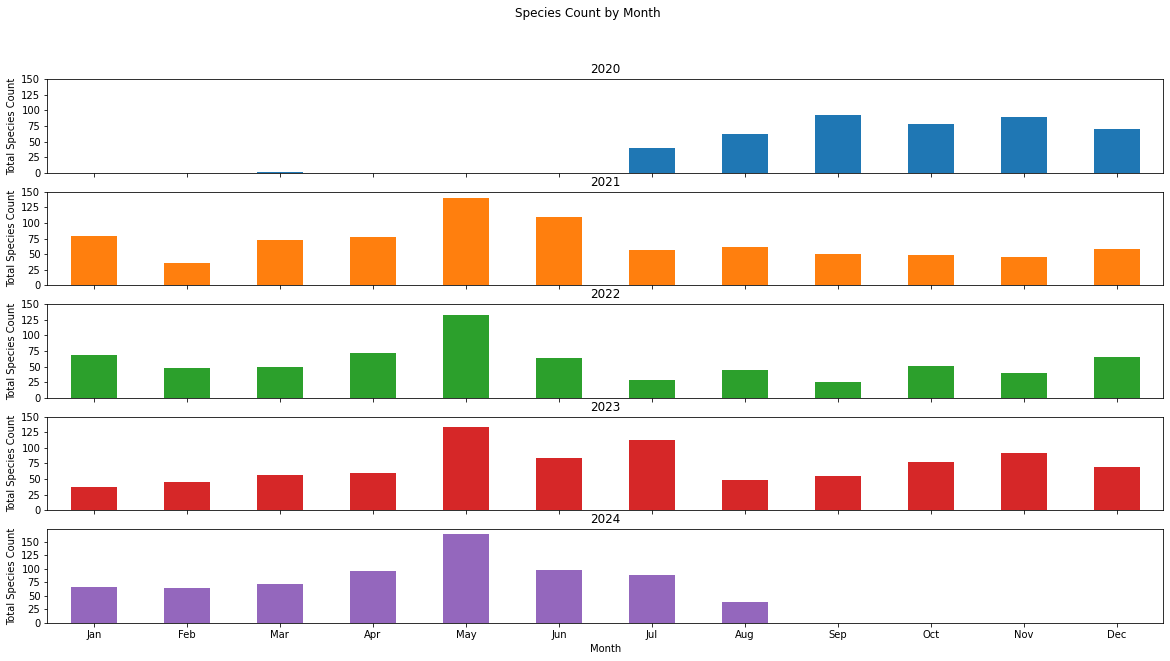

In [13]:
# Look at the last 5 years of data in a bar plot 
pivot.iloc[-5:].T.plot(kind='bar', 
                       rot=0, 
                       subplots=True, 
                       legend=False,  
                       yticks=[0, 25, 50, 75, 100, 125, 150],
                       ylabel='Total Species Count',
                       title='Species Count by Month',
                       figsize=(20, 10))

# pivot.T.plot(kind='bar', rot=0, subplots=True)